# Inversion of a 3D cube

In this notebook we show how to use a configuration file to run Hazel in a 3D cube, both in serial and parallel modes.

## Serial mode
Let's first a set of observations obtained from the GREGOR telescope as example. The observations consisted of a scan of an active region in which filaments are seen when observed in the core of the He I 10830 A line. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
import scipy.io as io
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2018.06.07


First read the observations and do some plots. The wavelength axis in the save file is given in displacement with respect to some reference wavelength, in this case 10830.0911 A.

dict_keys(['heperf', 'lambda'])
210


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


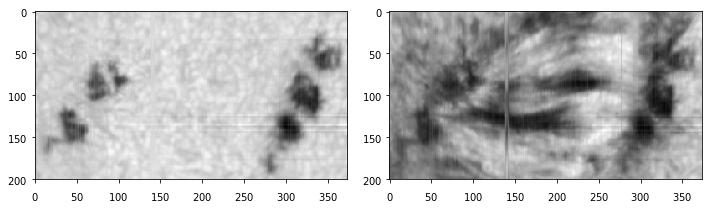

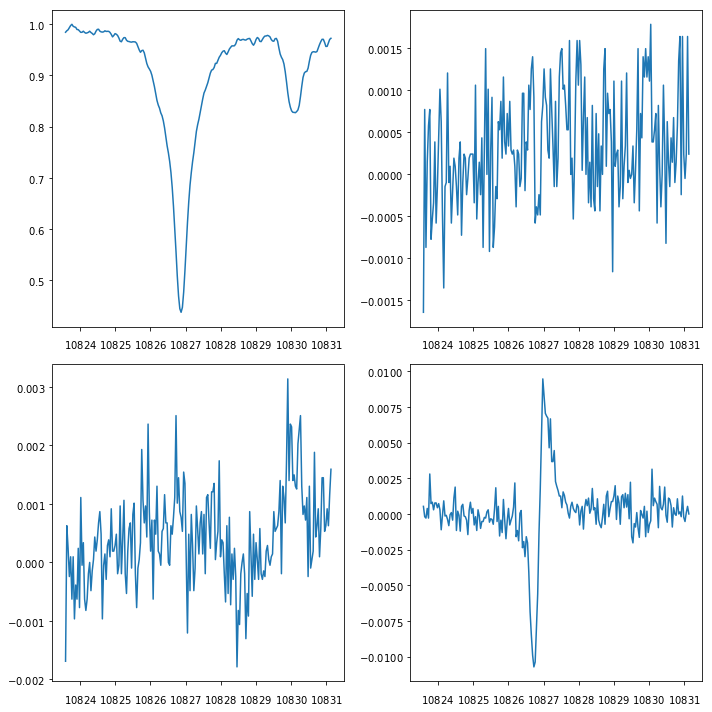

In [2]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/gregor_spot.sav')
print(tmp.keys())
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,181])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,210))
stokes[0,:] = tmp['heperf'][160,0,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[1,:] = tmp['heperf'][160,1,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[2,:] = tmp['heperf'][160,2,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[3,:] = tmp['heperf'][160,3,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
ax[0,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[0,:])
ax[0,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[1,:])
ax[1,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[2,:])
ax[1,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[3,:])

wvl = tmp['lambda'][0:-40]
stokes = stokes[:,:]
n_lambda = len(wvl)
print(n_lambda)

Now we want to prepare all files for a 2D inversion. First, like in 1D inversions, save the wavelength axis:

In [3]:
np.savetxt('10830_spot.wavelength', wvl+10830.0911, header='lambda')

Then, let's assume that we weight all wavelengths equally:

In [4]:
f = open('10830_spot.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_lambda):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
stokes.shape

(4, 210)

As an example, let's work only with a few pixels, but what I show in the following can be scaled to any size of the input observations. So, let's fix the number of pixels to be 10 (a small piece of 5x2 pixels in the map):

In [30]:
nx = 5
ny = 2
n_pixel = nx * ny
stokes_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)
sigma_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)
los_3d = np.zeros((n_pixel,3), dtype=np.float64)
boundary_3d = np.zeros((n_pixel,n_lambda,4), dtype=np.float64)

In [31]:
stokes = tmp['heperf'][160:160+nx,:,130:130+ny,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes = np.transpose(stokes, axes=(0,2,3,1)).reshape((n_pixel,210,4))
print(stokes.shape)

(10, 210, 4)


Now we fill all arrays with information from the osbervations, including, like in the 1D model, a very rough estimation of the noise standard deviation:

In [32]:
boundary = np.array([1.0,0.0,0.0,0.0])
for i in range(n_pixel):
    
    noise = np.std(stokes[i,0:20,1])
    
    stokes_3d[i,:,:] = stokes[i,:,:]
    sigma_3d[i,:,:] = noise*np.ones((210,4))
    los_3d[i,:] = np.array([0.0,0.0,90.0])
    boundary_3d[i,:,:] = np.repeat(np.atleast_2d(boundary), n_lambda, axis=0)

f = h5py.File('10830_spot_stokes.h5', 'w')
db_stokes = f.create_dataset('stokes', stokes_3d.shape, dtype=np.float64)
db_sigma = f.create_dataset('sigma', sigma_3d.shape, dtype=np.float64)
db_los = f.create_dataset('LOS', los_3d.shape, dtype=np.float64)
db_boundary = f.create_dataset('boundary', boundary_3d.shape, dtype=np.float64)
db_stokes[:] = stokes_3d
db_sigma[:] = sigma_3d
db_los[:] = los_3d
db_boundary[:] = boundary_3d
f.close()

So we are now ready for the inversion. Let's print first the configuration file and then do a simple inversion for a 1D input file. You can see that we are including two atmospheres, a photosphere to explain the Si I line and a chromosphere to explain the He I multiplet. We also give some rough intervals for the parameters.

In [26]:
%cat conf_spot_3d.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 2

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Topology = ph1 -> ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spot.wavelength'
    Wavelength weight file = '10830_spot.weights'
    Observations file = '10830_spot_stokes.h5'    
    Weights Stokes I = 1.0, 0.1, 0.0, 0.0
    Weights Stokes Q = 0.0, 10.0, 0.0, 0.0
    Weights Stokes U = 0.0, 10.0, 0.0, 0.0
    Weights Stokes V = 0.0, 1.0, 0.0, 0.0
    Mask file = None

[Atmospheres]

    [[Chromosphere 1]]
    Name = c

Let's invert these profiles in a non-MPI mode, which can be done directly in Python:

In [33]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_spot_3d.ini', working_mode='inversion')
iterator.use_model(model=mod)
iterator.run_all_pixels()

 30%|███       | 3/10 [01:38<03:48, 32.67s/it]/scratch/Dropbox/GIT/hazel2/hazel/transforms.py:37: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
100%|██████████| 10/10 [04:52<00:00, 29.20s/it]


We see that we found a solution with a relatively good $\chi^2$ and now let's analyze the results. For your specific case, you probably need some trial and error on the Stokes weights and range of parameters to find a reliable solution.

(npix,nrand,ncycle,nstokes,nlambda) -> (10, 1, 2, 4, 210)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


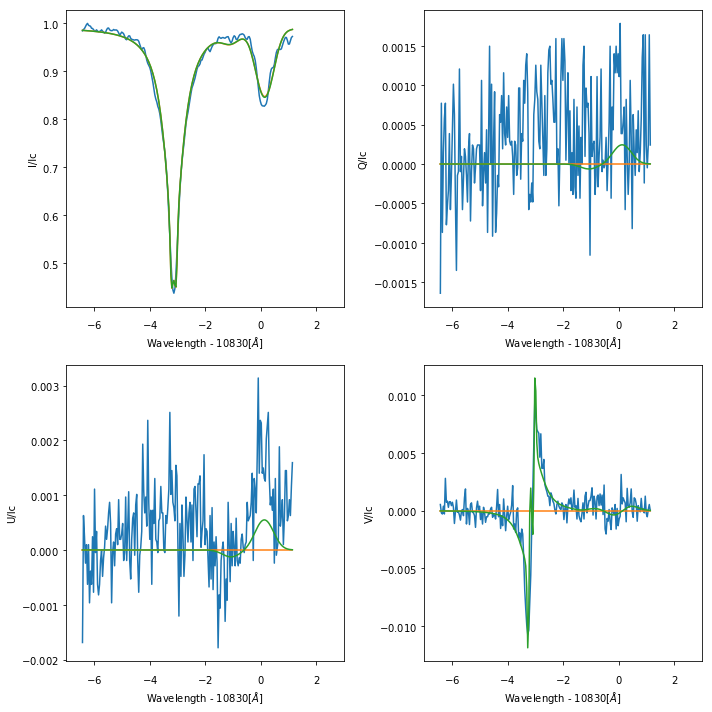

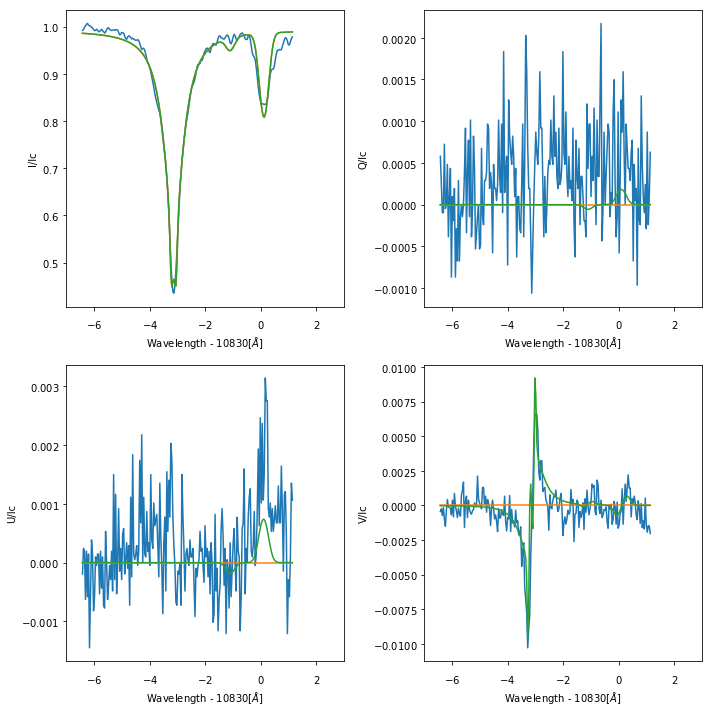

In [34]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

for k in range(2):
    fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
    ax = ax.flatten()
    for i in range(4):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[k,:,i])
        for j in range(2):
            ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][k,0,j,i,:])

    for i in range(4):
        ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
        ax[i].set_ylabel('{0}/Ic'.format(label[i]))
        ax[i].set_xlim([-7,3])

    pl.tight_layout()

f.close()

Then do some 2D plots. However, they are not very representative for such a small FOV.

['Bx', 'Bx_err', 'By', 'By_err', 'Bz', 'Bz_err', 'a', 'a_err', 'beta', 'beta_err', 'deltav', 'deltav_err', 'ff', 'ff_err', 'tau', 'tau_err', 'v', 'v_err']
(10, 1, 2, 1)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


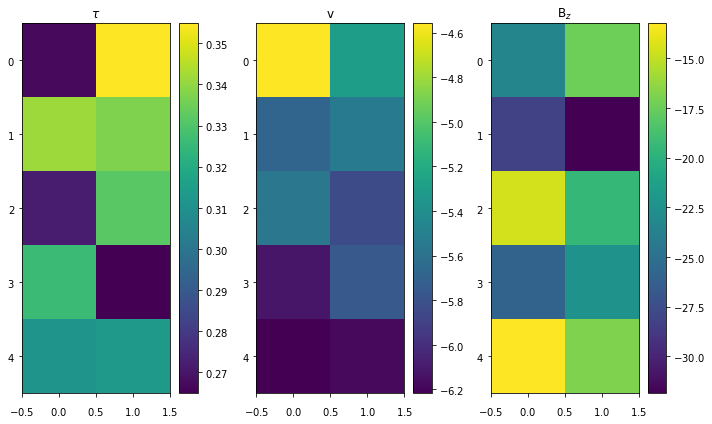

In [54]:
f = h5py.File('output.h5', 'r')
print(list(f['ch1'].keys()))
tau = np.squeeze(f['ch1']['tau'][:,:,-1,:])
v = np.squeeze(f['ch1']['v'][:,:,-1,:])
Bz = np.squeeze(f['ch1']['Bz'][:,:,-1,:])

fig, ax = pl.subplots(figsize=(10,6), nrows=1, ncols=3)
im = ax[0].imshow(tau.reshape((nx,ny)), cmap=pl.cm.viridis)
pl.colorbar(im, ax=ax[0])
ax[0].set_title(r'$\tau$')

im = ax[1].imshow(v.reshape((nx,ny)), cmap=pl.cm.viridis)
pl.colorbar(im, ax=ax[1])
ax[1].set_title('v')

im = ax[2].imshow(Bz.reshape((nx,ny)), cmap=pl.cm.viridis)
pl.colorbar(im, ax=ax[2])
ax[2].set_title(r'B$_z$')

print(f['ch1']['tau'].shape)
f.close()

## Parallel mode
For inverting the profiles in a multi-core machine, you need to create a Python file (e.g., script.py) with the following content:

    iterator = hazel.Iterator(use_mpi=True)
    mod = hazel.Model('conf_spot_3d.ini', rank=iterator.get_rank())
    iterator.use_model(model=mod)
    iterator.run_all_pixels()
    
and run it with
    
    mpiexec -n n_cpu python script.py